<a href="https://colab.research.google.com/github/ya-stack/lightly/blob/main/Iightly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lightly

     |████████████████████████████████| 323 kB 4.3 MB/s 
     |████████████████████████████████| 527 kB 64.9 MB/s 
     |████████████████████████████████| 145 kB 77.2 MB/s 
     |████████████████████████████████| 112 kB 74.9 MB/s 
     |████████████████████████████████| 74 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 829 kB 57.5 MB/s 
     |████████████████████████████████| 133 kB 69.2 MB/s 
     |████████████████████████████████| 952 kB 57.0 MB/s 
     |████████████████████████████████| 396 kB 73.9 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 271 kB 75.0 MB/s 
     |████████████████████████████████| 144 kB 72.0 MB/s 
     |████████████████████████████████| 160 kB 73.5 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=6d76afe3ac66095dd4d9cac8cb1b9332063f01c6fc2e9226cdd2414115720e5b
  Stored i

**SimCLR**

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

Cloning into 'clothing-dataset'...
remote: Enumerating objects: 5792, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 5792 (delta 13), reused 3 (delta 1), pack-reused 5766
Receiving objects: 100% (5792/5792), 152.92 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
path_to_data = '/content/clothing-dataset/images'

 *The images from the dataset have been taken from above when the clothing was on a table, bed or floor. 
Therefore, we can make use of additional augmentations such as vertical flip or random rotation (90 degrees). 
By adding these augmentations we learn our model invariance regarding the orientation of the clothing piece. 
E.g. we don’t care if a shirt is upside down but more about the strcture which make it a shirt.* 

In [ ]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 5
input_size = 128
num_ftrs = 32

In [ ]:
len(os.listdir("/content/clothing-dataset/images"))

5756

In [ ]:
collate_fn = lightly.data.SimCLRCollateFunction(
    input_size = input_size,
    vf_prob=0.5,
    rr_prob=0.5
)

# We create a torchvision transformation for embedding the dataset after
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [ ]:
gpus = 1 if torch.cuda.is_available() else 0

model = SimCLRModel()
trainer = pl.Trainer(
    max_epochs=max_epochs, gpus=gpus, progress_bar_refresh_rate=100
)
trainer.fit(model, dataloader_train_simclr)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXe

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
embeddings, filenames

(array([[0.00266113, 0.02857033, 0.05128435, ..., 0.016575  , 0.04837998,
         0.07975292],
        [0.01209674, 0.01488176, 0.03957011, ..., 0.00834136, 0.01377031,
         0.01691434],
        [0.01624646, 0.02108388, 0.04477349, ..., 0.03275219, 0.01926382,
         0.04151313],
        ...,
        [0.02373207, 0.00681469, 0.02082808, ..., 0.02001837, 0.02501323,
         0.00226764],
        [0.02511483, 0.00937668, 0.03888662, ..., 0.03049872, 0.03605567,
         0.00102998],
        [0.00140247, 0.01093088, 0.0741717 , ..., 0.01595207, 0.03839308,
         0.05625429]]),
 ['00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg',
  '00070a23-9faf-4682-8243-59f307880f4b.jpg',
  '000d31f6-44b5-4758-8d86-c4fcfb234392.jpg',
  '001068a8-86c3-4029-a9d9-1e27015e7e64.jpg',
  '00143901-a14c-4600-960f-7747b4a3a8cd.jpg',
  '00149032-3dd6-426e-9bc0-d53032536a42.jpg',
  '00208c77-ee58-4b63-bc1a-b9b3aa4f1be0.jpg',
  '0028956e-9962-46f0-ad45-2c42f8a59d94.jpg',
  '002e88c2-e0ce-4a4b-9670-eddc3d99accc.j

In [ ]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            print(fname)
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')

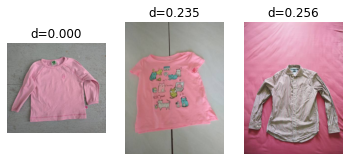

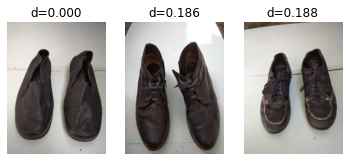

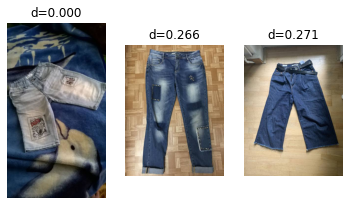

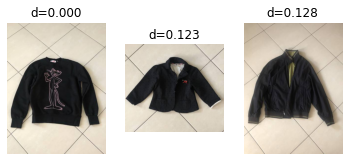

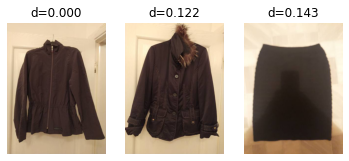

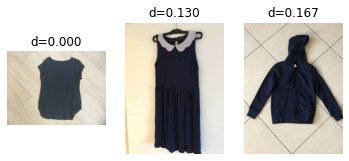

In [ ]:
plot_knn_examples(embeddings, filenames)

In [ ]:
from lightly import train_embedding_model, embed_images

# first we train our model for 10 epochs
checkpoint = train_embedding_model(input_dir='/content/clothing-dataset/images', trainer={'max_epochs': 10})

# let's embed our 'cats' dataset using our trained model
embeddings, labels, filenames = embed_images(input_dir='/content/clothing-dataset/images', checkpoint=checkpoint)

# now, let's inspect the shape of our embeddings
print(embeddings.shape)

/usr/local/lib/python3.7/dist-packages/lightly/cli/train_cli.py:66: UserWarning: Training a self-supervised model with a small batch size: 16! Small batch size may harm embedding quality. You can specify the batch size via the loader key-word: loader.batch_size=BSZ
  warnings.warn(msg)
Downloading: "https://storage.googleapis.com/models_boris/whattolabel-resnet18-simclr-d32-w1.0-i-085d0693.pth" to /root/.cache/torch/hub/checkpoints/whattolabel-resnet18-simclr-d32-w1.0-i-085d0693.pth


  0%|          | 0.00/42.8M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | _SimCLR    | 11.2 M
1 | criterion | NTXentLoss | 0     
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.762    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Best model is stored at: /content/lightly_epoch_8.ckpt


Compute efficiency: 0.87: 100%|██████████| 360/360 [00:26<00:00, 13.47it/s]


(5756, 32)


In [ ]:
list(set(labels))

[0]